# PCA on Fors2

Use Eigenvectors constructed by PCA decomposition from SL sample.
Project Fors2 spectra on those Eigenvector to extract their PCA coefficients wrt SL eigenvectors
Reconstruct Fors2 sample over Full wavelength range using their PCA decomposition


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2022/12/29
- update : 2022/12/29
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

## Import

In [1]:
import os,sys,re
from astropy.io import fits
from astropy.table import Table

In [42]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import ticker

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
from astropy.io import fits
import copy

In [5]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [6]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [7]:
from def_raw_seds import *

In [8]:
from raw_data_analysis import *

In [9]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [10]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

## Configuration

### SL

In [11]:
filename = "datatools/pcamethod1_SL_eigenvectorandcoeff.fits"
hdu = fits.open(filename)

In [12]:
hdu.info()

Filename: datatools/pcamethod1_SL_eigenvectorandcoeff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (6362, 553)   float64   
  1                1 ImageHDU         8   (10, 550)   float64   
  2                1 ImageHDU         8   (6361, 10)   float64   


In [13]:
data1=hdu[0].data
hdr1 = hdu[0].header
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6362                                                  
NAXIS2  =                  553                                                  
EXTEND  =                    T                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of StarLight                                                    

In [14]:
data2=hdu[1].data
hdr2 = hdu[1].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   10                                                  
NAXIS2  =                  550                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 spectra coefficients                                       

In [15]:
coeffs=data2

In [16]:
coeffs.shape

(550, 10)

In [17]:
NCOEFFS=coeffs.shape[1]

In [18]:
data3=hdu[2].data
hdr3 = hdu[2].header
hdr3

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6361                                                  
NAXIS2  =                   10                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 Eigen Vectors                                              

In [19]:
eigenvectors=data3

In [20]:
eigenvectors.shape

(10, 6361)

In [21]:
NVEC=eigenvectors.shape[0]

In [22]:
NSED_SL = data1.shape[0]-3
NWL_SL = data1.shape[1]-1

In [23]:
wavelengths_sl = data1[0,1:] 
flambdas_average_sl = data1[1,1:] 
flambdas_std_sl = data1[2,1:] 
spec_sl = data1[3:,1:] 
all_numbers_sl = data1[3:,0] 

In [24]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED_SL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED_SL), alpha=1)

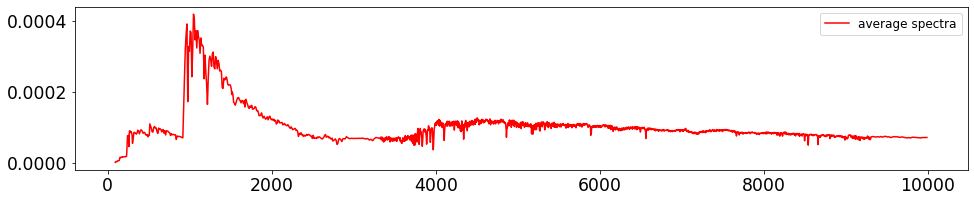

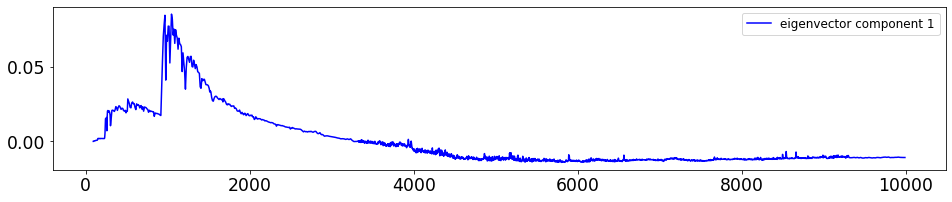

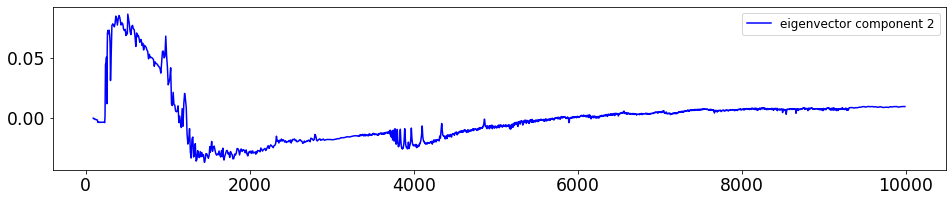

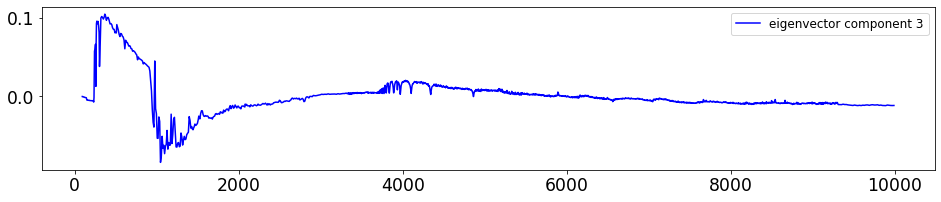

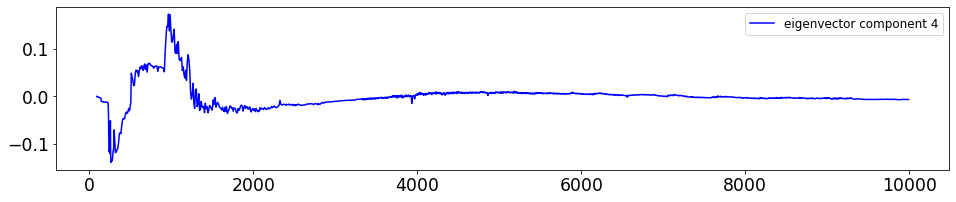

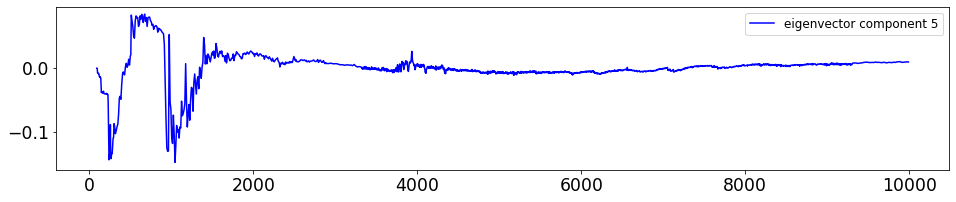

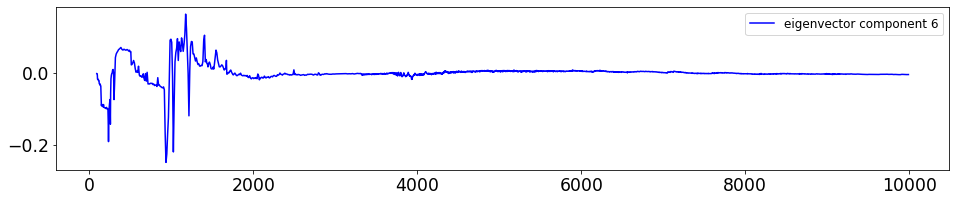

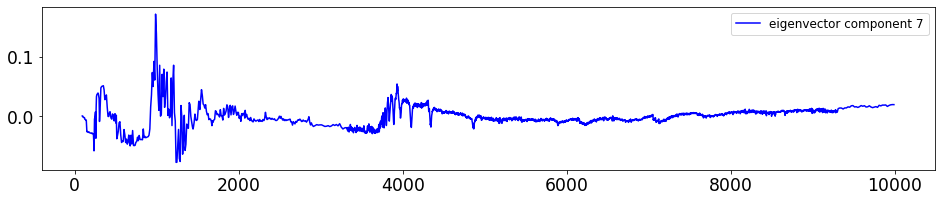

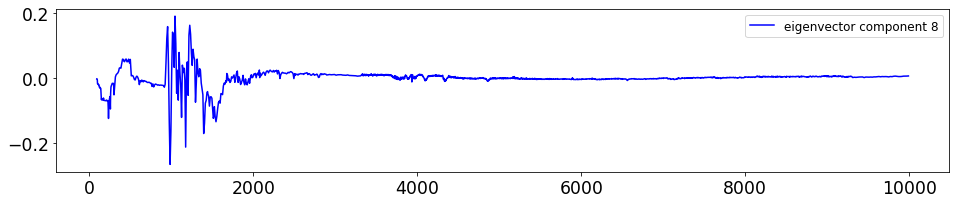

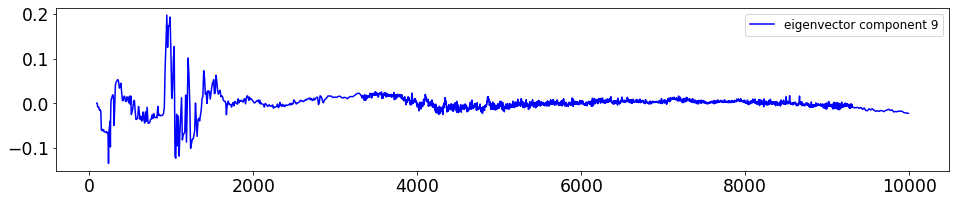

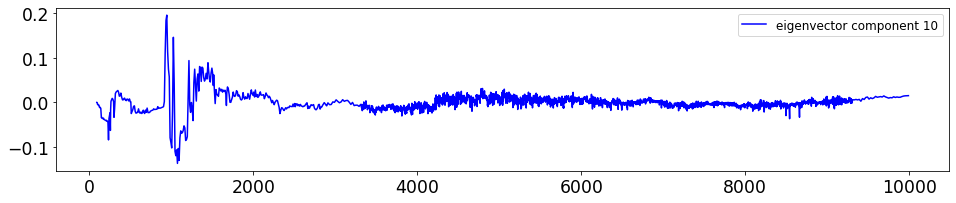

In [25]:
plt.figure(figsize=(16,3))
plt.plot(wavelengths_sl,flambdas_average_sl,'r-',label="average spectra")
plt.legend()
for idx in range(NCOEFFS):
    fig=plt.figure(figsize=(16,3))
    ax=fig.add_subplot(1,1,1)
    label=f"eigenvector component {idx+1}"
    ax.plot(wavelengths_sl,eigenvectors[idx,:],'b-',label=label)
    ax.legend()

### Fors2

### Catalog

In [26]:
t = Table.read(filename_fits_catalog)

/Users/dagoret/anaconda3/lib/python3.9/site-packages/astropy/io/fits/connect.py:235: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


In [27]:
t

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
1,,13.52815,-28.40486,0.55409,,20.79,166227,55,10.0,1,"[OII],H8,K,H"
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"
4,,13.52216,-28.40914,0.68653,,21.62,205959,123,10.6,1,"[OII],H9,K,H,G,H{beta}"
7,,13.50974,-28.42972,0.32371,,22.34,97111,11,16.7,6,"[OII],H{beta},[OIII],H{alpha}"
9,,13.50219,-28.40641,0.29266,,21.6,87798,58,13.1,1,"H9,H8,K,H"
11,,13.49724,-28.39487,0.62688,,22.09,188063,17,24.3,3,"[OII],H10,H8,K,H,H{delta}"
12,,13.49584,-28.39125,0.2973,,21.97,89189,30,14.8,2,"[OII],H10,H9,H8,K,H"


In [28]:
filename_fors2 = 'datatools/Fors2_data.fits'

In [29]:
hdu = fits.open(filename_fors2)

In [30]:
hdu.info()

Filename: datatools/Fors2_data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   (6364, 553)   float64   


In [31]:
data=hdu[0].data
hdr = hdu[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6364                                                  
NAXIS2  =                  553                                                  
DATAWLS = 'data[0,3:]'                                                          
DATALLAV= 'data[1,3:]'                                                          
DATALLST= 'data[2,3:]'                                                          
DATAFL  = 'data[3:,3:]'                                                         
DATANUM = 'data[3:,0]'                                                          
DAWLMIN = 'data[3:,1]'                                                          
DAWLMAX = 'data[3:,2]'                                                          
COMMENT Spectra of Fors2    

In [32]:
NSED_FO = data.shape[0]-3
NWL_FO = data.shape[1]-3

In [33]:
wavelengths_fo = data[0,3:] 
flambdas_average_fo = data[1,3:] 
flambdas_std_fo = data[2,3:] 
spec_fo = data[3:,3:] 
all_numbers_fo = data[3:,0] 
all_wlmin_fo   = data[3:,1] 
all_wlmax_fo   = data[3:,2] 

Text(0, 0.5, 'normalized flux')

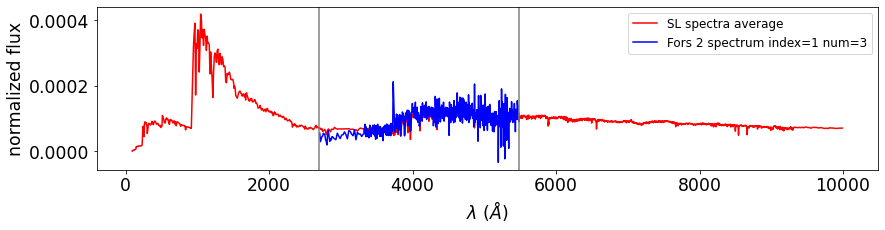

In [34]:
idx=1
fig=plt.figure(figsize=(14,3))
ax=fig.add_subplot(1,1,1)
ax.plot(wavelengths_fo,flambdas_average_fo,'r-',label="SL spectra average")
num=all_numbers_fo[idx]
wlmin=all_wlmin_fo[idx] 
wlmax=all_wlmax_fo[idx] 
ax.plot(wavelengths_fo,spec_fo[idx],'b-',label=f"Fors 2 spectrum index={idx} num={num:.0f}")
ax.axvline(wlmin,color="grey")
ax.axvline(wlmax,color="grey")
ax.legend()
ax.set_xlabel('$\lambda\ (\AA)$')
ax.set_ylabel('normalized flux')

# PCA


https://www.astroml.org/astroML-notebooks/chapter7/astroml_chapter7_Dimensionality_Reduction.html

In [64]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

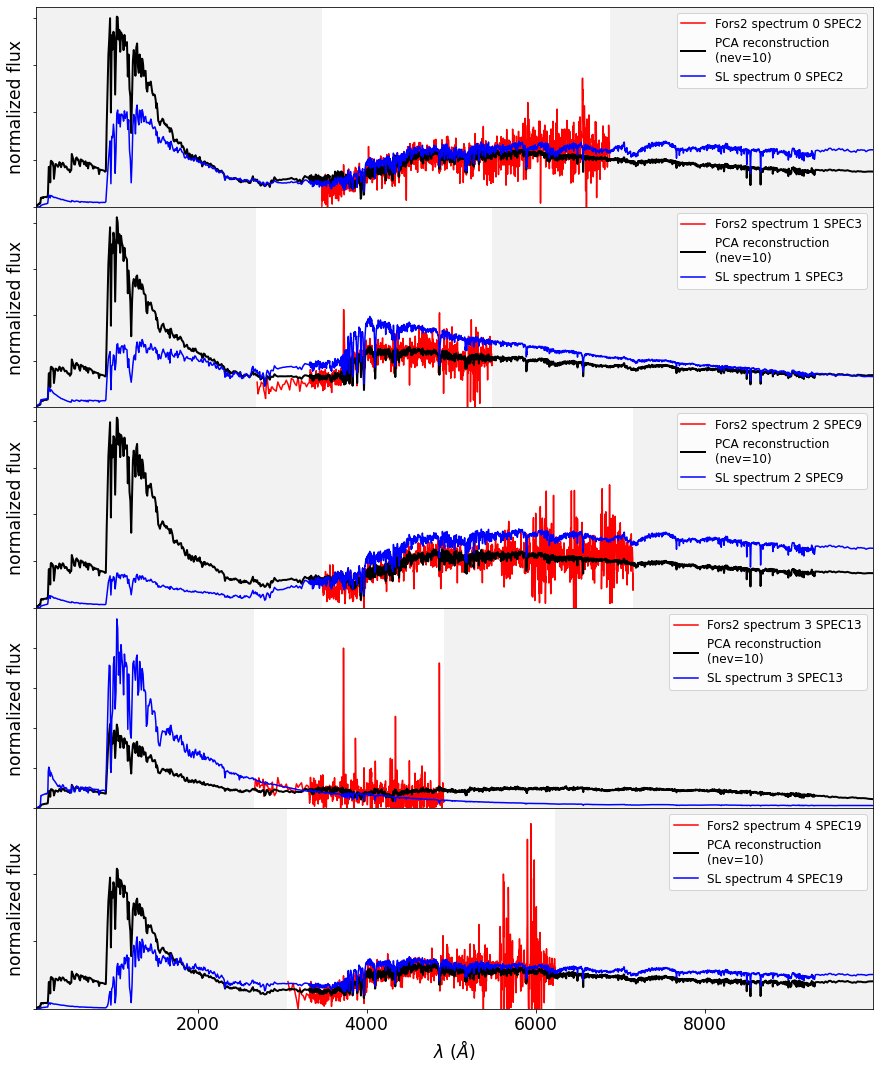

In [71]:
evecs = eigenvectors
mu = flambdas_average_sl
#norms = data['norms']
#mask = data['mask']

#------------------------------------------------------------
# plot the results

# plot the results
i_plot = ((wavelengths_sl >=0 ) & (wavelengths_sl <= 10000))
wavelengths = wavelengths_sl[i_plot]


specnums = [0, 1, 2, 3 , 4]
subplots = [511, 512, 513, 514, 515]

fig = plt.figure(figsize=(14, 16))
fig.subplots_adjust(left=0.09, bottom=0.08, hspace=0, right=0.92, top=0.95)

for subplot, i in zip(subplots, specnums):
    
    i_mask = ((wavelengths_fo >= all_wlmin_fo[i]) & (wavelengths_fo <= all_wlmax_fo[i]))
    wavelengths_mask = wavelengths_fo[i_mask]
    
    ax = fig.add_subplot(subplot)

    # compute eigen-coefficients
    spectra_i_centered = spec_fo[i]  - flambdas_average_fo
    spectra_i_centered [np.isnan(spectra_i_centered)] = 0
    coeffs = np.dot(spectra_i_centered, evecs.T)

    # blank out masked regions
    num=all_numbers_fo[i]
    spectra_i = spec_fo[i]
    #mask_i = mask[i]
    #spectra_i[mask_i] = np.nan

    # plot the raw masked spectrum
    ax.plot(wavelengths_fo, spectra_i, '-', color='r',label=f"Fors2 spectrum {i} SPEC{num:.0f}", lw=1.5)

    # plot two levels of reconstruction
    for nev in [10]:
        if nev == 0:
            label = 'mean'
        else:
            label = 'PCA reconstruction\n(nev=%i)' % nev
        spectra_i_recons = (mu + np.dot(coeffs[:nev], evecs[:nev]))
        ax.plot(wavelengths_sl, spectra_i_recons, label=label, color='k',lw=2)
        
    # plot SL
    num_sl = all_numbers_sl[i]
    ax.plot(wavelengths_sl, spec_sl[i], '-', color='b',label=f"SL spectrum {i} SPEC{num_sl:.0f}", lw=1.5)

    # plot shaded background in masked region
    ylim = ax.get_ylim()
    ylim = (0,ylim[1])
    xlim = ax.get_xlim()
    #mask_shade = ylim[0] + mask[i][i_plot].astype(float) * ylim[1]
    #plt.fill(np.concatenate([wavelength[:1], wavelength, wavelength[-1:]]),
    #         np.concatenate([[ylim[0]], mask_shade, [ylim[0]]]),
    #         lw=0, fc='k', alpha=0.2)
    
    plt.fill_between([xlim[0],all_wlmin_fo[i]],[ylim[1],ylim[1]],lw=0, fc='k', alpha=0.05)
    plt.fill_between([all_wlmax_fo[i],xlim[1]],[ylim[1],ylim[1]],lw=0, fc='k', alpha=0.05)

    ax.set_xlim(wavelengths[0], wavelengths[-1])
    ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    #if subplot == 311:
    ax.legend(loc=1)

    ax.set_xlabel('$\lambda\ (\AA)$')
    ax.set_ylabel('normalized flux')

plt.show()